In [1]:
%reload_ext autoreload
%autoreload 2

# Rutgers trace-set analysis

In [2]:
import glob
from os import path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'png'}

SEED = 42
np.random.seed(SEED)

mpl_rc = {
    'figure.dpi': 92,
    'savefig.dpi': 128,
}

sns.set(
    context='notebook',
    style='whitegrid',
    palette='husl',
    font='sans-serif',
    color_codes=True,
    rc=mpl_rc,
)

# scikit-learn over-dramatize with warnings. Silence them ...
def warn(*args, **kwargs):
    pass
import warnings
old_warn = warnings.showwarning
warnings.warn = warn


from datasets.trace1_Rutgers import TRANSFORM_OUTPUT_PATH
from datasets.trace1_Rutgers.transform import dtypes

files = glob.iglob(path.join(TRANSFORM_OUTPUT_PATH, '*.csv'))
df = [pd.read_csv(f, dtype=dtypes) for f in files]
df = pd.concat(df, ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218000 entries, 0 to 1217999
Data columns (total 7 columns):
seq         1218000 non-null uint16
src         1218000 non-null object
dst         1218000 non-null object
noise       1218000 non-null int8
received    1218000 non-null bool
error       1218000 non-null bool
rssi        1218000 non-null uint8
dtypes: bool(2), int8(1), object(2), uint16(1), uint8(1)
memory usage: 25.6+ MB


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

from datasets.helpers import plot_cm

In [4]:
df.describe()

,seq,noise,rssi
count,1.218000e+06,1.218000e+06,1.218000e+06
mean,1.505000e+02,-1.000000e+01,7.334187e+00
std,8.660209e+01,7.071071e+00,7.636434e+00
min,1.000000e+00,-2.000000e+01,0.000000e+00
25%,7.575000e+01,-1.500000e+01,0.000000e+00
50%,1.505000e+02,-1.000000e+01,6.000000e+00
75%,2.252500e+02,-5.000000e+00,1.300000e+01
max,3.000000e+02,0.000000e+00,4.000000e+01


# Observe random link

,seq,noise,rssi
count,300.000000,300.0,300.000000
mean,150.500000,0.0,2.823333
std,86.746758,0.0,1.677748
min,1.000000,0.0,0.000000
25%,75.750000,0.0,2.000000
50%,150.500000,0.0,3.000000
75%,225.250000,0.0,4.000000
max,300.000000,0.0,6.000000


,seq,src,dst,noise,received,error,rssi
759295,296,node2-1,node7-6,0,True,False,4
759296,297,node2-1,node7-6,0,True,False,4
759297,298,node2-1,node7-6,0,True,False,4
759298,299,node2-1,node7-6,0,True,False,3
759299,300,node2-1,node7-6,0,True,False,3


<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 759000 to 759299
Data columns (total 7 columns):
seq         300 non-null uint16
src         300 non-null object
dst         300 non-null object
noise       300 non-null int8
received    300 non-null bool
error       300 non-null bool
rssi        300 non-null uint8
dtypes: bool(2), int8(1), object(2), uint16(1), uint8(1)
memory usage: 8.8+ KB


None

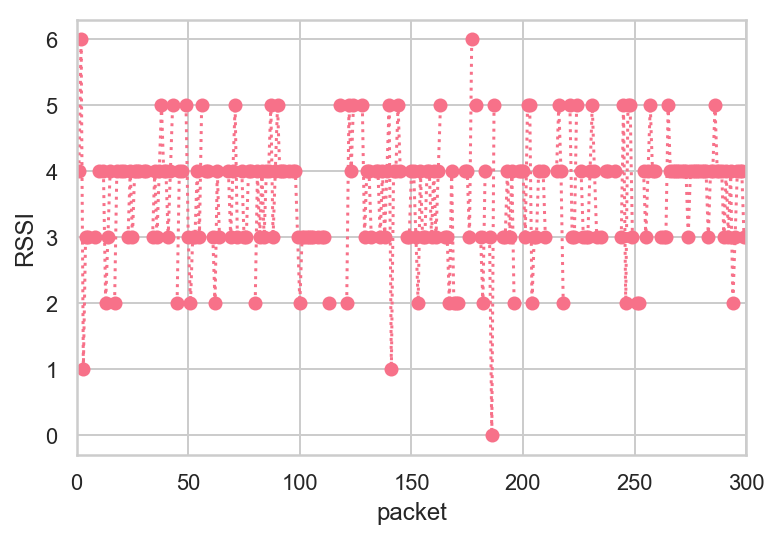

In [5]:
link = df.loc[(df.src=='node2-1') & (df.dst=='node7-6') & (df.noise==0)].copy()

display(link.describe())
display(link.tail())
display(link.info())

link.loc[~link.received, 'rssi'] = np.nan

f, ax = plt.subplots()
ax.plot('seq', 'rssi', ':o', data=link)
ax.set_xlim(0, 300)
ax.set_ylabel('RSSI')
ax.set_xlabel('packet')

plt.show()
plt.close(f)

del link

# General/Overall Analysis

In [6]:
labels = ('good', 'interm.', 'bad')

/home/gcerar/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


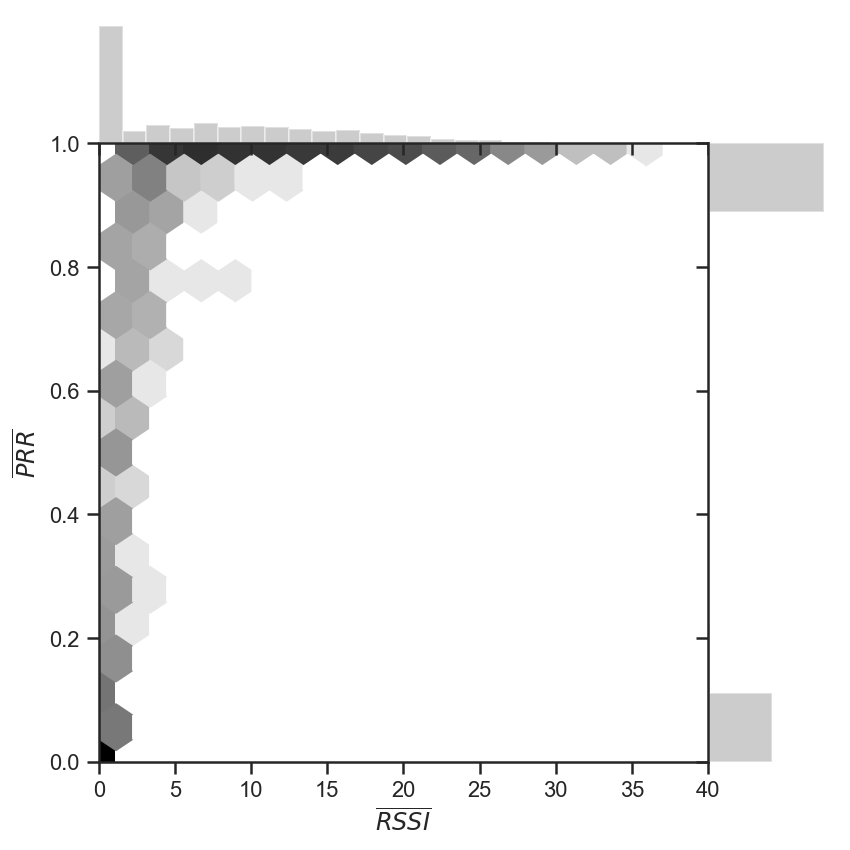

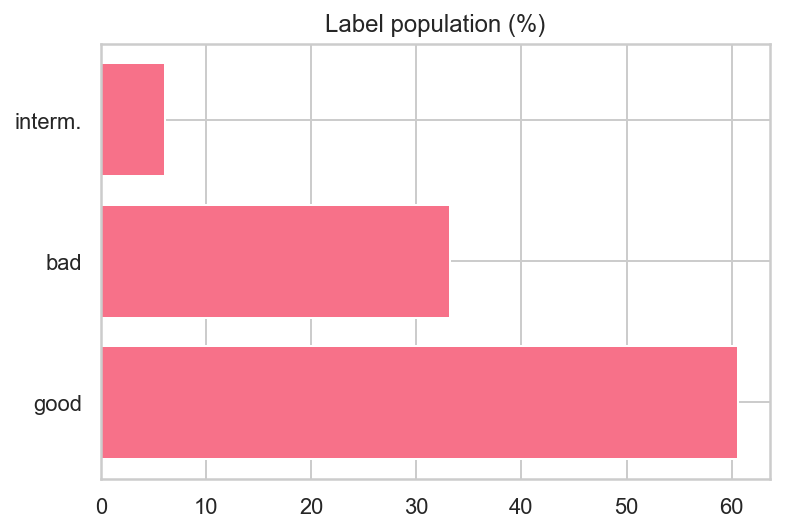

In [7]:
from collections import Counter

def set_class(value):
    if np.isnan(value): return None
    if value >= 0.9: return 'good'
    if value <= 0.1: return 'bad'
    return 'interm.'

def ratio(x): return x.sum() / len(x.index)


data = df.groupby(['src', 'dst', 'noise'], as_index=False) \
    .agg({'rssi': ['mean', 'std'], 'received': ratio})

# Merge multiindex column names
data.columns = data.columns.map('|'.join).str.strip('|')

# Add labels according to common pattern
data['label'] = data['received|ratio'].apply(set_class)

with sns.axes_style('ticks'):
    g = sns.jointplot(
        data=data, 
        x='rssi|mean', 
        y='received|ratio',
        color='.5',
        kind='hexbins',
        bins='log',
        xlim=(0, df['rssi'].max()),
        ylim=(0, 1),
        space=0
    )
    g.set_axis_labels('$\overline{RSSI}$', '$\overline{PRR}$')

classes = data['label']

c = Counter(classes)

values = sum(c.values())
for key in c.keys(): # Normalize
    c[key] /= values
    c[key] *= 100
    

f, ax = plt.subplots()
ax.barh(list(c.keys()), list(c.values()))
ax.set_title('Label population (%)')
plt.show(f)
plt.close(f)
    
del c

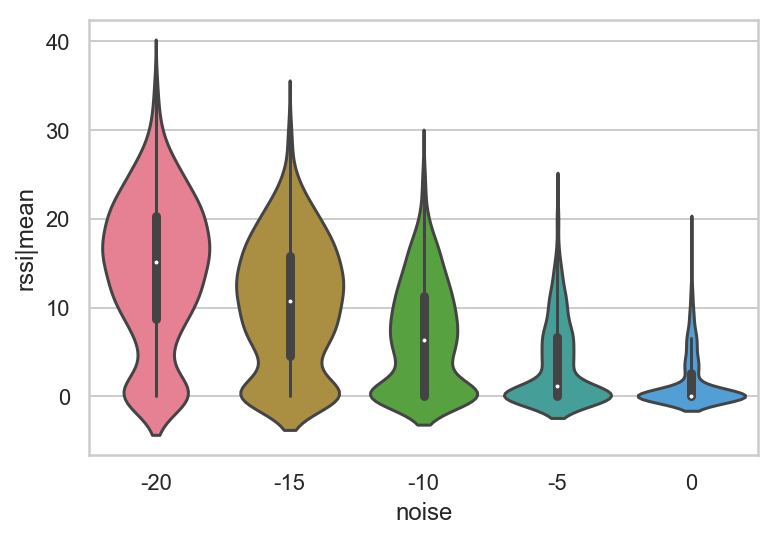

In [8]:
sns.violinplot(data=data, x='noise', y='rssi|mean', scale='width')

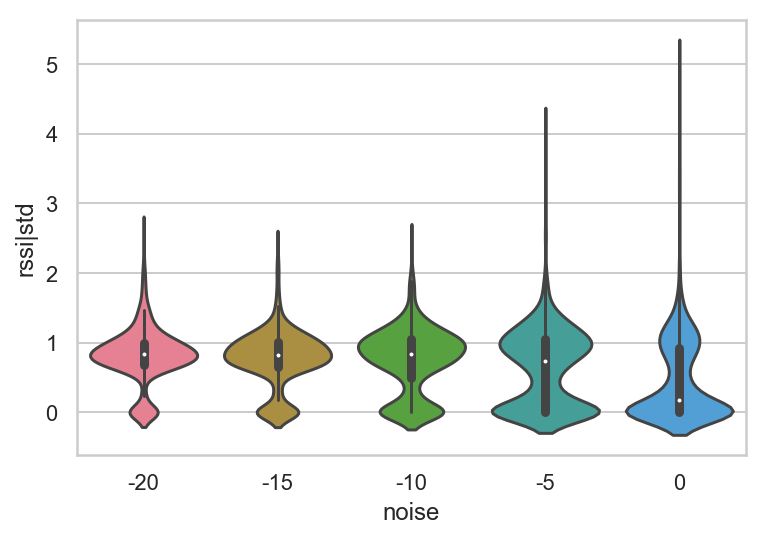

In [9]:
sns.violinplot(data=data, x='noise', y='rssi|std', scale='width')

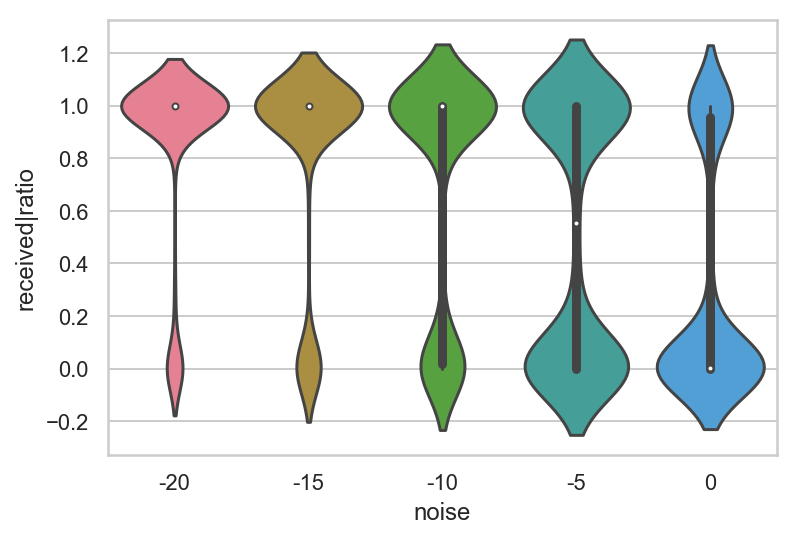

In [10]:
sns.violinplot(data=data, x='noise', y='received|ratio', scale='width')

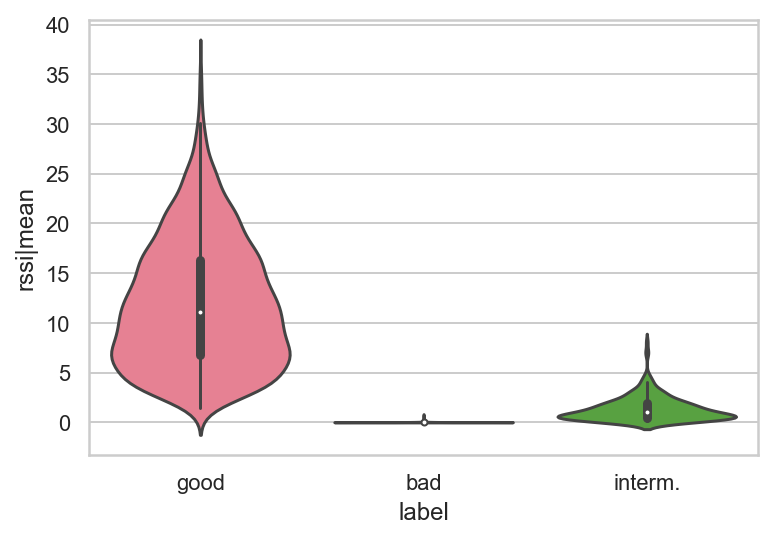

In [11]:
sns.violinplot(data=data, x='label', y='rssi|mean', scale='width')

# Introduce synthetic features avg(RSSI), sd(RSSI) PRR, PRR+1 over designated window as well as polynomial features

In [12]:
group = df.groupby(['src', 'dst', 'noise'], as_index=False)

w = 20
df[f'avg(rssi)'] = group \
    .apply(lambda g: g.sort_values('seq')['rssi'].rolling(w).mean()) \
    .reset_index(level=0)['rssi'].astype(np.float32)

df[f'sd(rssi)'] = group \
    .apply(lambda g: g.sort_values('seq')['rssi'].rolling(w).std()) \
    .reset_index(level=0)['rssi'].astype(np.float32)

df[f'prr'] = group \
    .apply(lambda g: g.sort_values('seq')['received'].rolling(w).sum() / w) \
    .reset_index(level=0)['received'].astype(np.float32)

df[f'prr+1'] = group \
    .apply(lambda g: (g.sort_values('seq')['received'].rolling(w).sum() / w).shift(-w)) \
    .reset_index(level=0)['received'].astype(np.float32)

df['label'] = df['prr+1'].apply(set_class)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218000 entries, 0 to 1217999
Data columns (total 12 columns):
seq          1218000 non-null uint16
src          1218000 non-null object
dst          1218000 non-null object
noise        1218000 non-null int8
received     1218000 non-null bool
error        1218000 non-null bool
rssi         1218000 non-null uint8
avg(rssi)    1140860 non-null float32
sd(rssi)     1140860 non-null float32
prr          1140860 non-null float32
prr+1        1136800 non-null float32
label        1136800 non-null object
dtypes: bool(2), float32(4), int8(1), object(3), uint16(1), uint8(1)
memory usage: 53.4+ MB


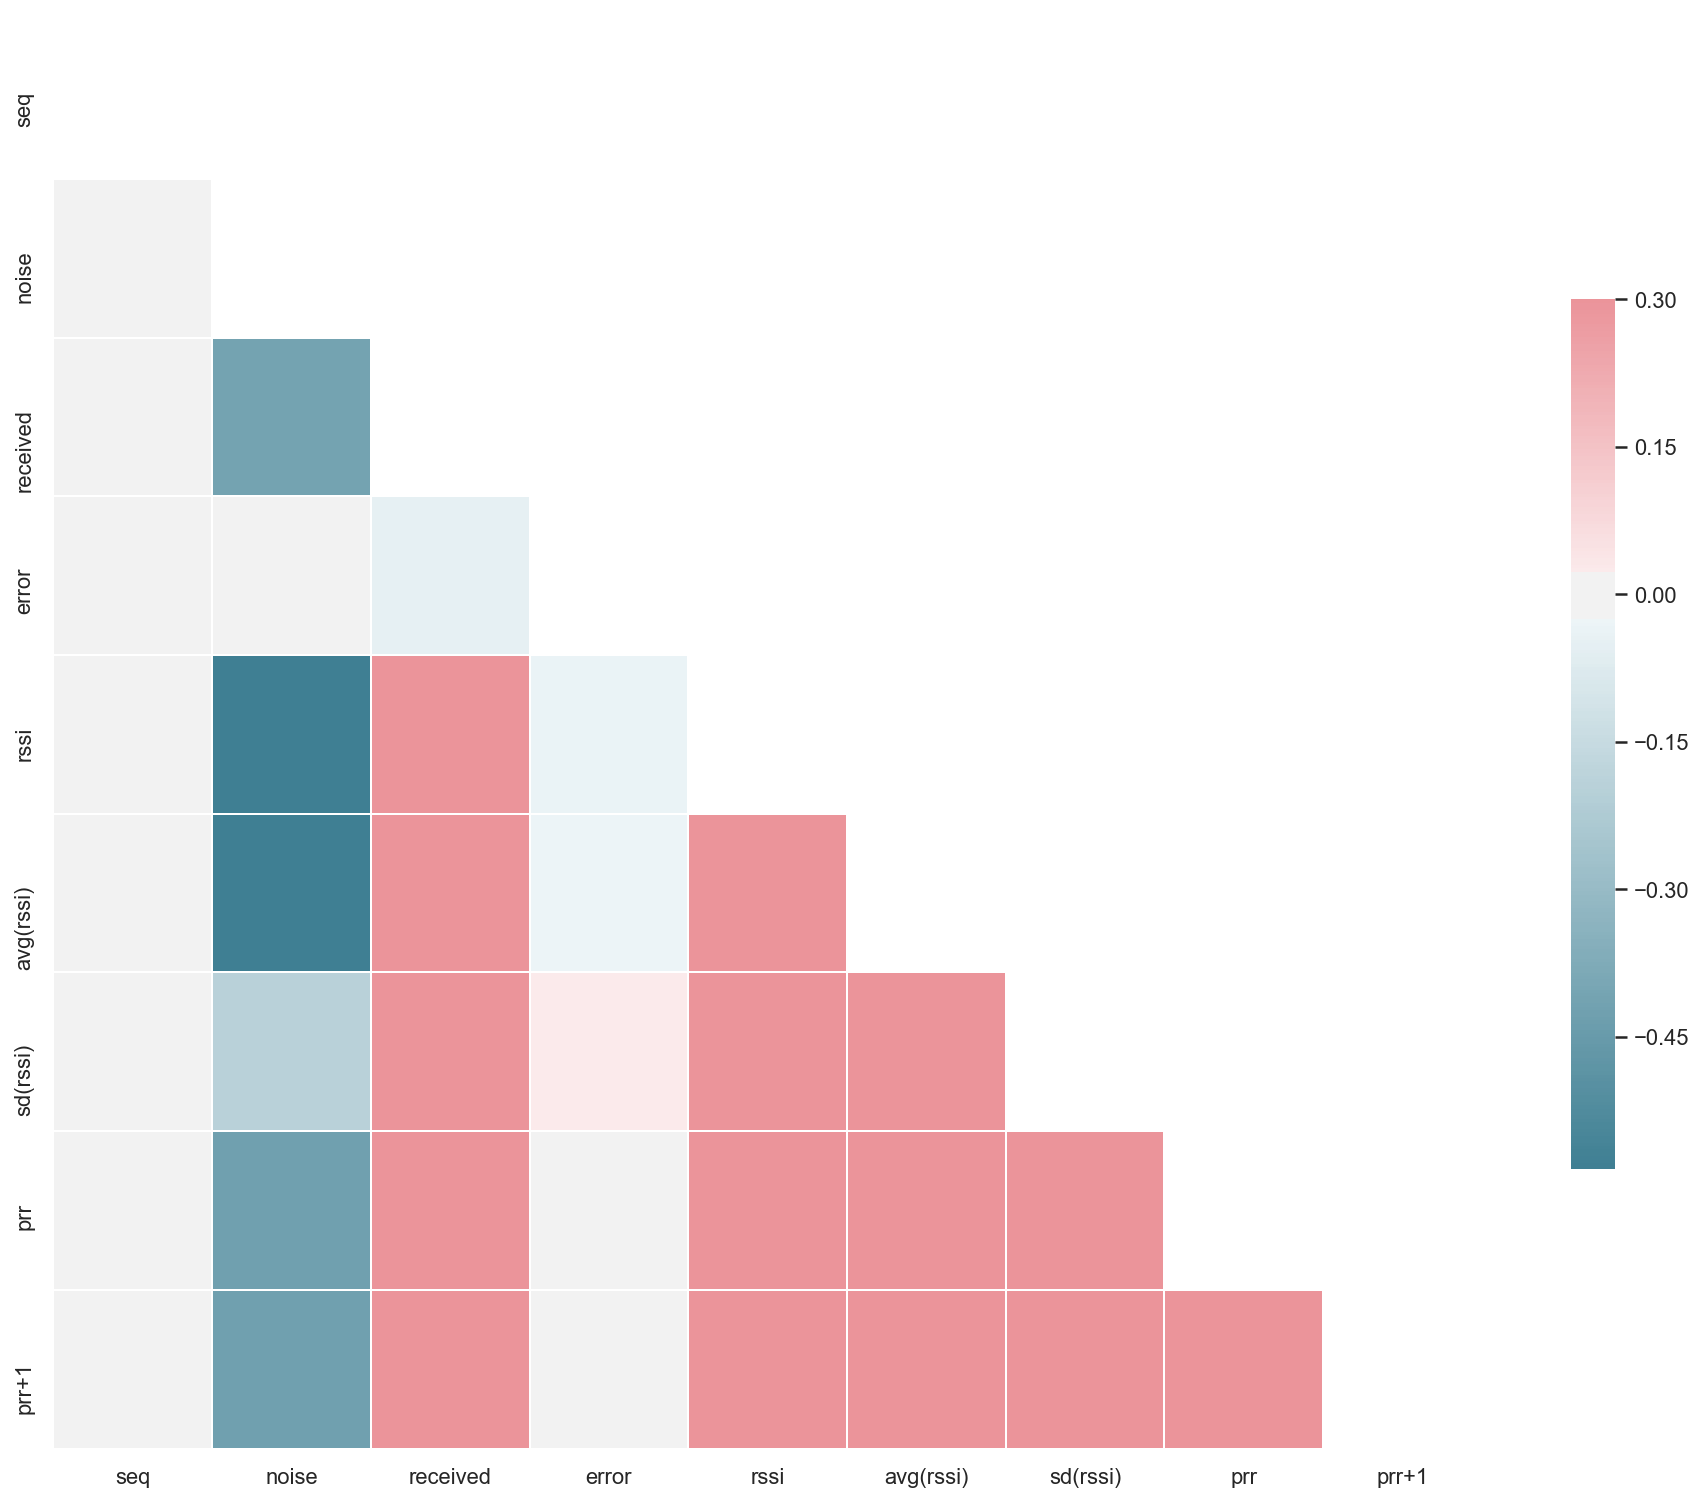

In [13]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(16,16))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show(f)
plt.close(f)

In [14]:
# Introduce polynomial features (handpicked interactions with themself and others)
from sklearn.preprocessing import PolynomialFeatures
picked_features = ['rssi', 'avg(rssi)', 'sd(rssi)']

df.dropna(subset=picked_features, inplace=True)

X, rest = df.loc[:, picked_features], df.drop(picked_features, axis=1)

poly = PolynomialFeatures(degree=4, include_bias=True).fit(X)

# Next line converts back to pandas, while preserving column names
X = pd.DataFrame(poly.transform(X).astype(np.float32), columns=poly.get_feature_names(X.columns), index=X.index)

df = pd.concat([X, rest], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1140860 entries, 19 to 1217999
Data columns (total 44 columns):
1                            1140860 non-null float32
rssi                         1140860 non-null float32
avg(rssi)                    1140860 non-null float32
sd(rssi)                     1140860 non-null float32
rssi^2                       1140860 non-null float32
rssi avg(rssi)               1140860 non-null float32
rssi sd(rssi)                1140860 non-null float32
avg(rssi)^2                  1140860 non-null float32
avg(rssi) sd(rssi)           1140860 non-null float32
sd(rssi)^2                   1140860 non-null float32
rssi^3                       1140860 non-null float32
rssi^2 avg(rssi)             1140860 non-null float32
rssi^2 sd(rssi)              1140860 non-null float32
rssi avg(rssi)^2             1140860 non-null float32
rssi avg(rssi) sd(rssi)      1140860 non-null float32
rssi sd(rssi)^2              1140860 non-null float32
avg(rssi)^3           

In [15]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

tmp = df.drop(['src', 'dst', 'seq', 'error', 'noise', 'label'], axis=1).dropna()
scaler = StandardScaler().fit(tmp)

tmp = pd.DataFrame(
    scaler.transform(tmp).astype(np.float32),
    columns=tmp.columns,
    index=tmp.index, 
)

r2 = []
for column in tmp.columns:
    coef = r2_score(tmp['prr+1'], tmp[column])
    r2.append([column, coef])

r2 = pd.DataFrame(r2, columns=('feature', 'R^2')).sort_values('R^2', ascending=False)

display(r2)

,feature,R^2
37,prr+1,1.000000e+00
36,prr,9.938769e-01
35,received,9.390172e-01
2,avg(rssi),4.855256e-01
1,rssi,4.779659e-01
8,avg(rssi) sd(rssi),4.540482e-01
6,rssi sd(rssi),4.216569e-01
3,sd(rssi),3.981063e-01
7,avg(rssi)^2,3.099741e-02
4,rssi^2,3.067797e-02


# Machine learning approach ...

Because it would be complex to tweak all the parameters at once, we change only per a time. Default pipeline is therefore: zero padding/interpolation, **{RSSI, avg(RSSI), sd(RSSI)}** feature vector, averaging & prediction on window size **20**, random oversampling, standard scaler, logistic regression & decision trees, when stratified 10-fold is used. 

## How different features (& combinations) affect linear & non-linear model

Stratified K-Fold will remove some bias because of the data. Here we choose different features and their combinations.

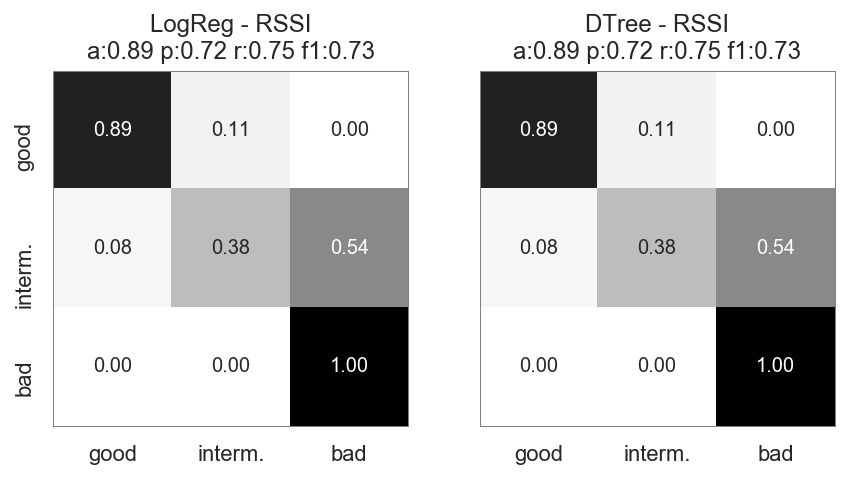

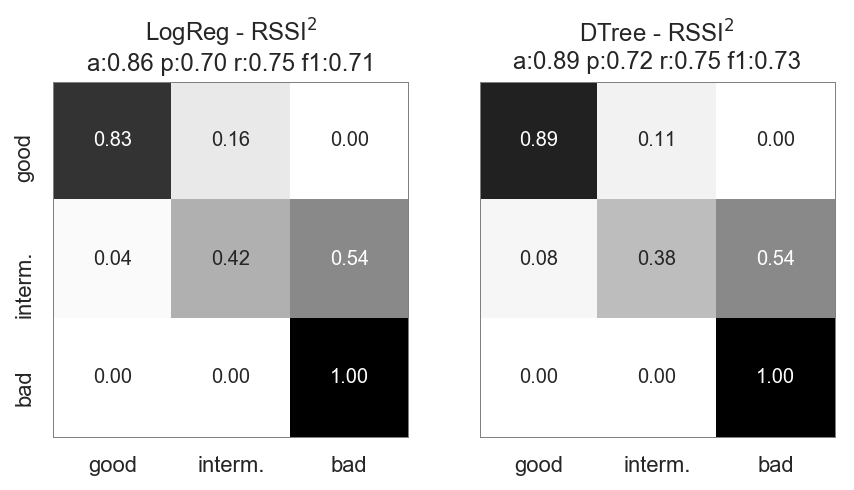

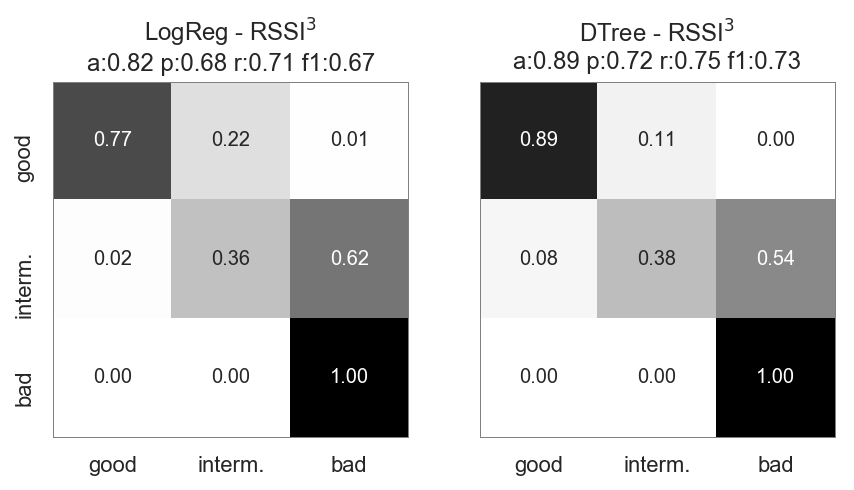

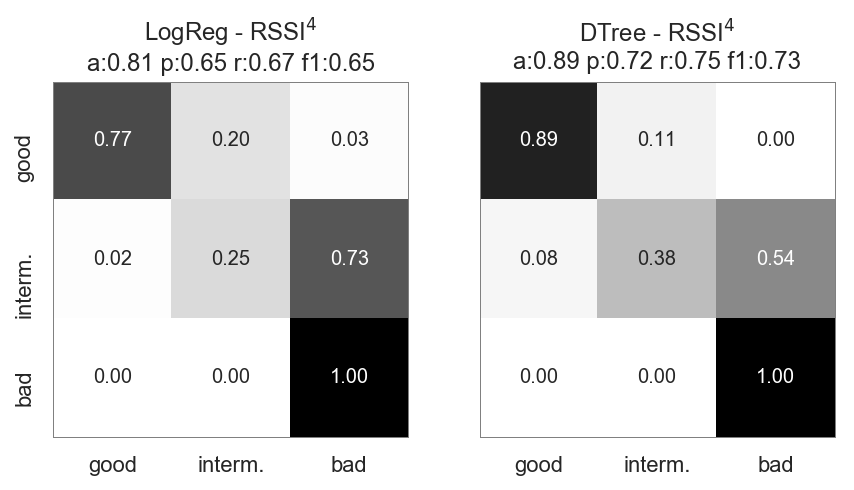

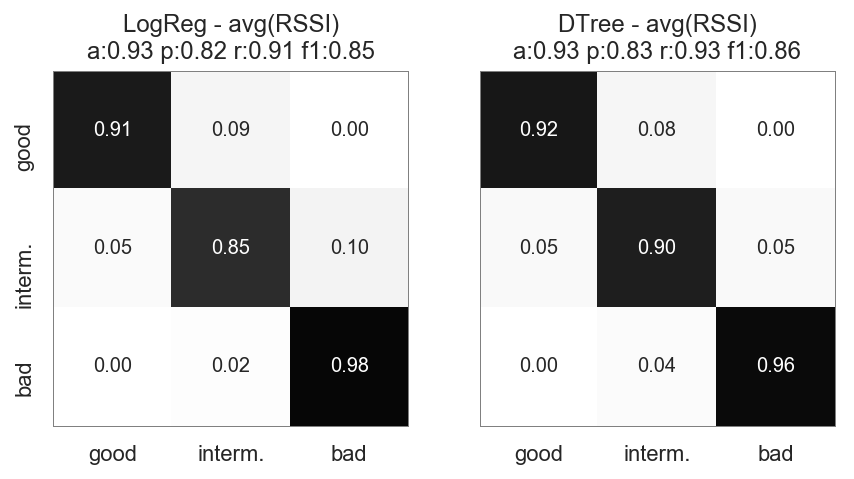

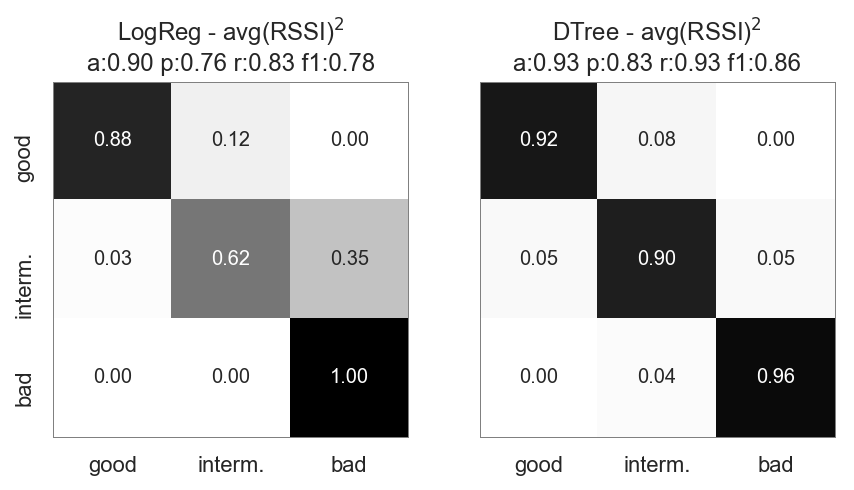

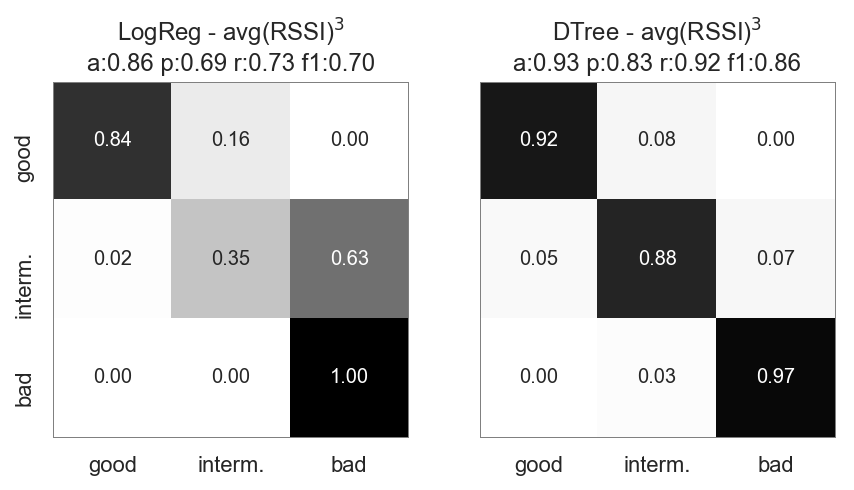

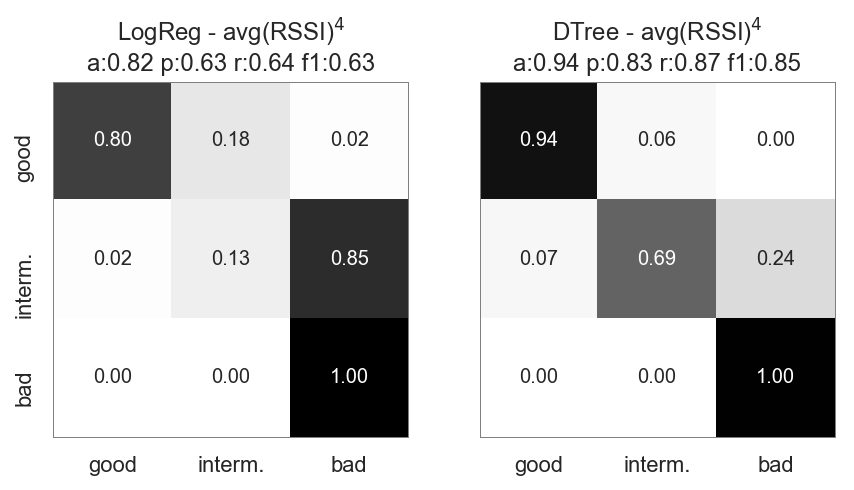

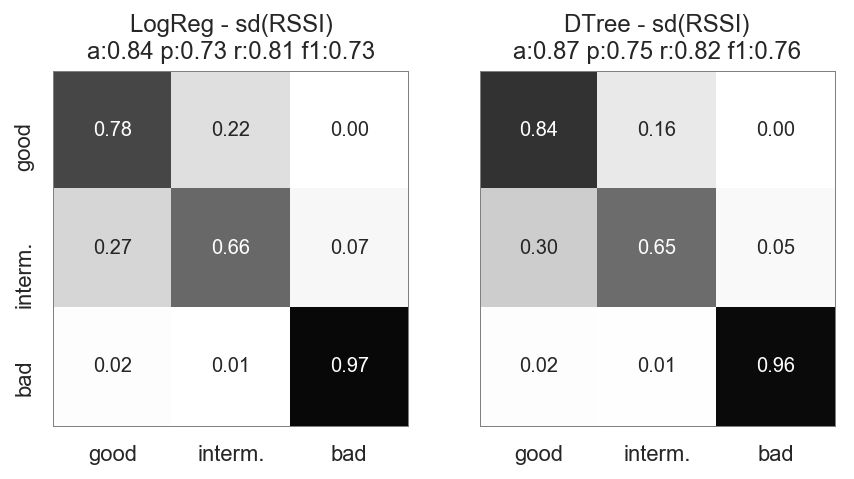

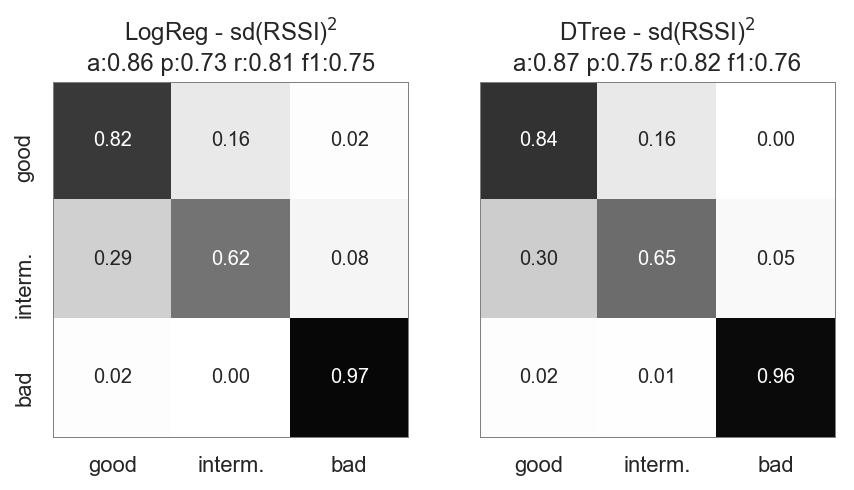

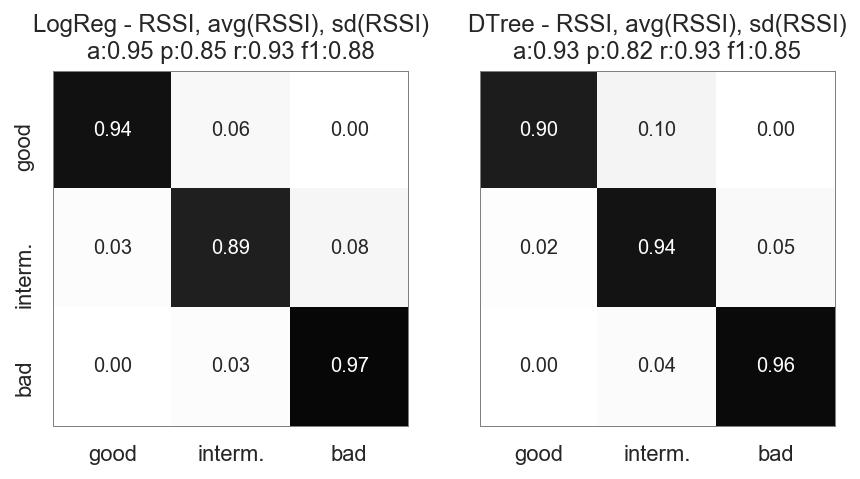

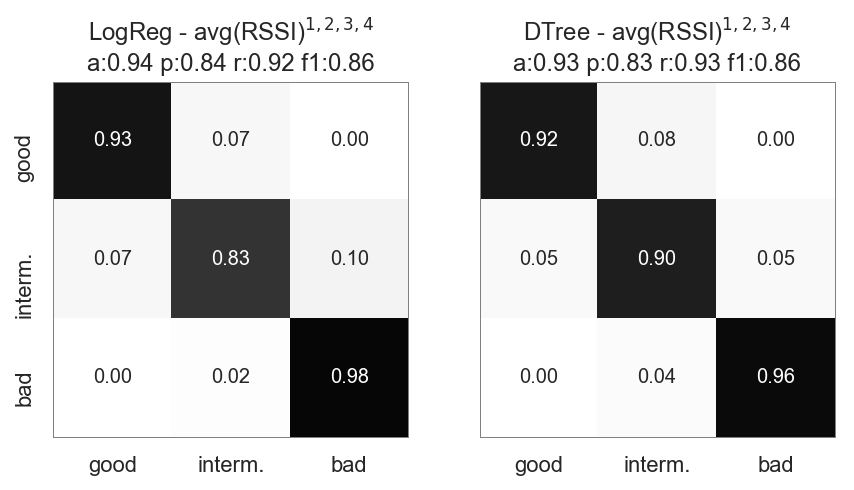

,features,accuracy,precision,recall,F1
20,"[rssi, avg(rssi), sd(rssi)]",0.947119,0.848583,0.934532,0.879114
22,"[avg(rssi), avg(rssi)^2, avg(rssi)^3, avg(rssi...",0.941178,0.836627,0.915299,0.864975
13,[avg(rssi)^3],0.934083,0.827483,0.922873,0.857799
23,"[avg(rssi), avg(rssi)^2, avg(rssi)^3, avg(rssi...",0.932666,0.826888,0.927115,0.857240
9,[avg(rssi)],0.932666,0.826888,0.927115,0.857240
11,[avg(rssi)^2],0.932666,0.826888,0.927115,0.857240
21,"[rssi, avg(rssi), sd(rssi)]",0.926268,0.820360,0.934670,0.851371
8,[avg(rssi)],0.930243,0.820279,0.914911,0.850271
15,[avg(rssi)^4],0.940020,0.828115,0.873283,0.847329
10,[avg(rssi)^2],0.900377,0.762105,0.830761,0.783296


In [16]:
dtree = make_pipeline(
    RandomOverSampler(random_state=SEED),
    StandardScaler(),
    DecisionTreeClassifier(max_depth=3, random_state=SEED),
)

logistic = make_pipeline(
    RandomOverSampler(random_state=SEED),
    StandardScaler(),
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=SEED),
)

feature_list = [
    ('RSSI', ['rssi']),
    ('RSSI$^2$', ['rssi^2']),
    ('RSSI$^3$', ['rssi^3']),
    ('RSSI$^4$', ['rssi^4']),
    
    ('avg(RSSI)', ['avg(rssi)']),
    ('avg(RSSI)$^2$', ['avg(rssi)^2']),
    ('avg(RSSI)$^3$', ['avg(rssi)^3']),
    ('avg(RSSI)$^4$', ['avg(rssi)^4']),
    
    ('sd(RSSI)', ['sd(rssi)']), 
    ('sd(RSSI)$^2$', ['sd(rssi)^2']),
    
    ('RSSI, avg(RSSI), sd(RSSI)', ['rssi', 'avg(rssi)', 'sd(rssi)']),
    ('avg(RSSI)$^{1,2,3,4}$', ['avg(rssi)', 'avg(rssi)^2', 'avg(rssi)^3', 'avg(rssi)^4']),
]

model_list = [
    ('LogReg', logistic),
    ('DTree', dtree),
]


results = []

for feature_name, features in feature_list:
    f, ax = plt.subplots(1, len(model_list), figsize=[7, 5], sharex=True, sharey=True)
    
    tmp = df[[*features, 'label']].dropna()    
    X, y = tmp[features], tmp['label'].ravel()
    
    for idx, (model_name, model) in enumerate(model_list):
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
        y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

        acc = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred, labels=labels, average='macro')
        rec = recall_score(y, y_pred, labels=labels, average='macro')
        f1 = f1_score(y, y_pred, labels=labels, average='macro')
        cm = confusion_matrix(y, y_pred, labels=labels)
        
        
        results.append([features, acc, prec, rec, f1])
                       
        title = f'{model_name} - {feature_name}\na:{acc:.2f} p:{prec:.2f} r:{rec:.2f} f1:{f1:.2f}'
        
        plot_cm(cm, labels=labels, ax=ax[idx], title=title)
        
    plt.show(f)
    plt.close(f)

results = pd.DataFrame(results, columns=('features', 'accuracy', 'precision', 'recall', 'F1'))
results = results.sort_values(['F1'], ascending=False)
display(results)

## Different models

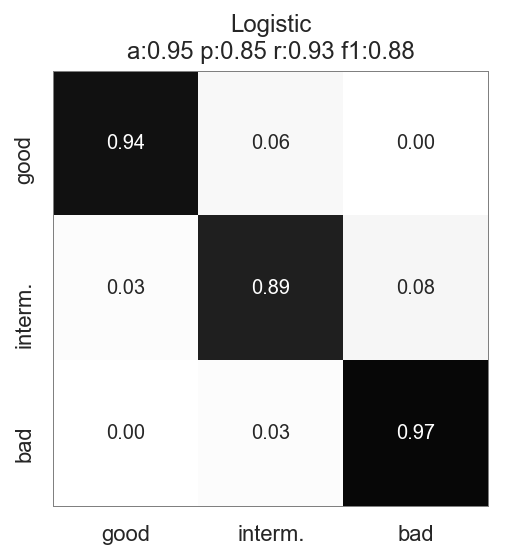

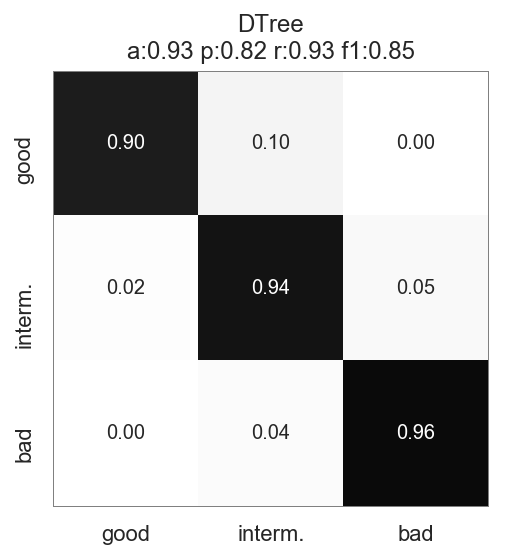

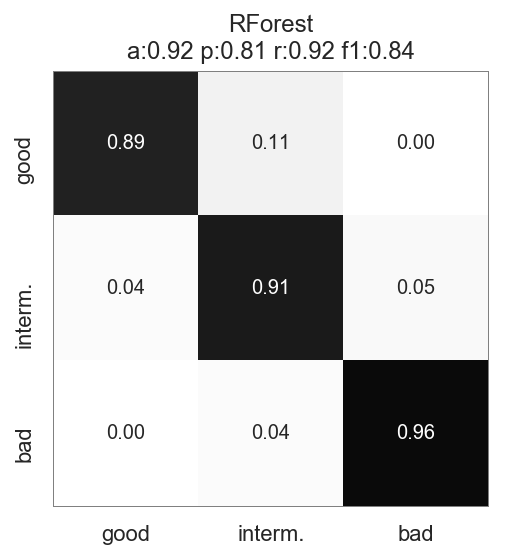

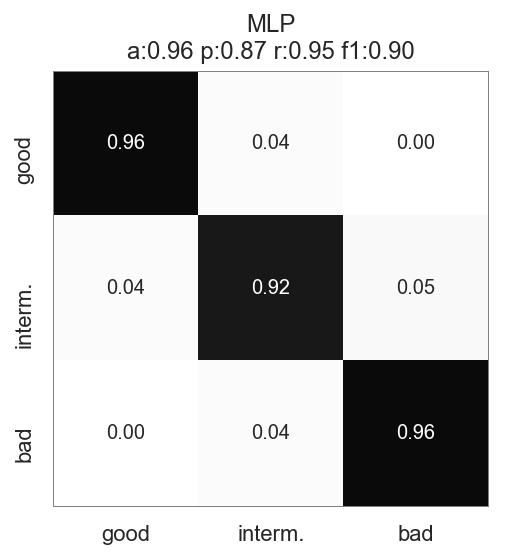

,model,accuracy,precision,recall,F1
3,MLP,0.959261,0.873498,0.947000,0.901607
0,Logistic,0.947119,0.848583,0.934532,0.879114
1,DTree,0.926268,0.820360,0.934670,0.851371
2,RForest,0.916195,0.807815,0.922537,0.836279


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


dtree = make_pipeline(
    RandomOverSampler(random_state=SEED),
    StandardScaler(),
    DecisionTreeClassifier(max_depth=3, random_state=SEED)
)

logistic = make_pipeline(
    RandomOverSampler(random_state=SEED),
    StandardScaler(),
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=SEED)
)

rforest = make_pipeline(
    RandomOverSampler(random_state=SEED),
    StandardScaler(),
    RandomForestClassifier(max_depth=3, random_state=SEED)
)

svm = make_pipeline(
    RandomOverSampler(random_state=SEED),
    StandardScaler(),
    SVC(kernel='linear', random_state=SEED)
)

mlp = make_pipeline(
    RandomOverSampler(random_state=SEED),
    StandardScaler(),
    MLPClassifier(random_state=SEED),
)

model_list = (
    ('Logistic', logistic),
    ('DTree', dtree),
    ('RForest', rforest),
    #('SVM', svm),
    ('MLP', mlp),
)

features = ['rssi', 'avg(rssi)', 'sd(rssi)']

results = []

for model_name, model in model_list:
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
    
    tmp = df[[*features, 'label']].dropna()
    X, y = tmp[features], tmp['label'].ravel()
    
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=4)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, labels=labels, average='macro')
    rec = recall_score(y, y_pred, labels=labels, average='macro')
    f1 = f1_score(y, y_pred, labels=labels, average='macro')
    cm = confusion_matrix(y, y_pred, labels=labels)


    results.append([model_name, acc, prec, rec, f1])

    title = f'{model_name}\na:{acc:.2f} p:{prec:.2f} r:{rec:.2f} f1:{f1:.2f}'
    
    f, ax = plt.subplots()

    plot_cm(cm, labels=labels, ax=ax, title=title)
        
    plt.show(f)
    plt.close(f)

results = pd.DataFrame(results, columns=('model', 'accuracy', 'precision', 'recall', 'F1'))
results = results.sort_values(['F1'], ascending=False)
display(results)

## Different window sizes

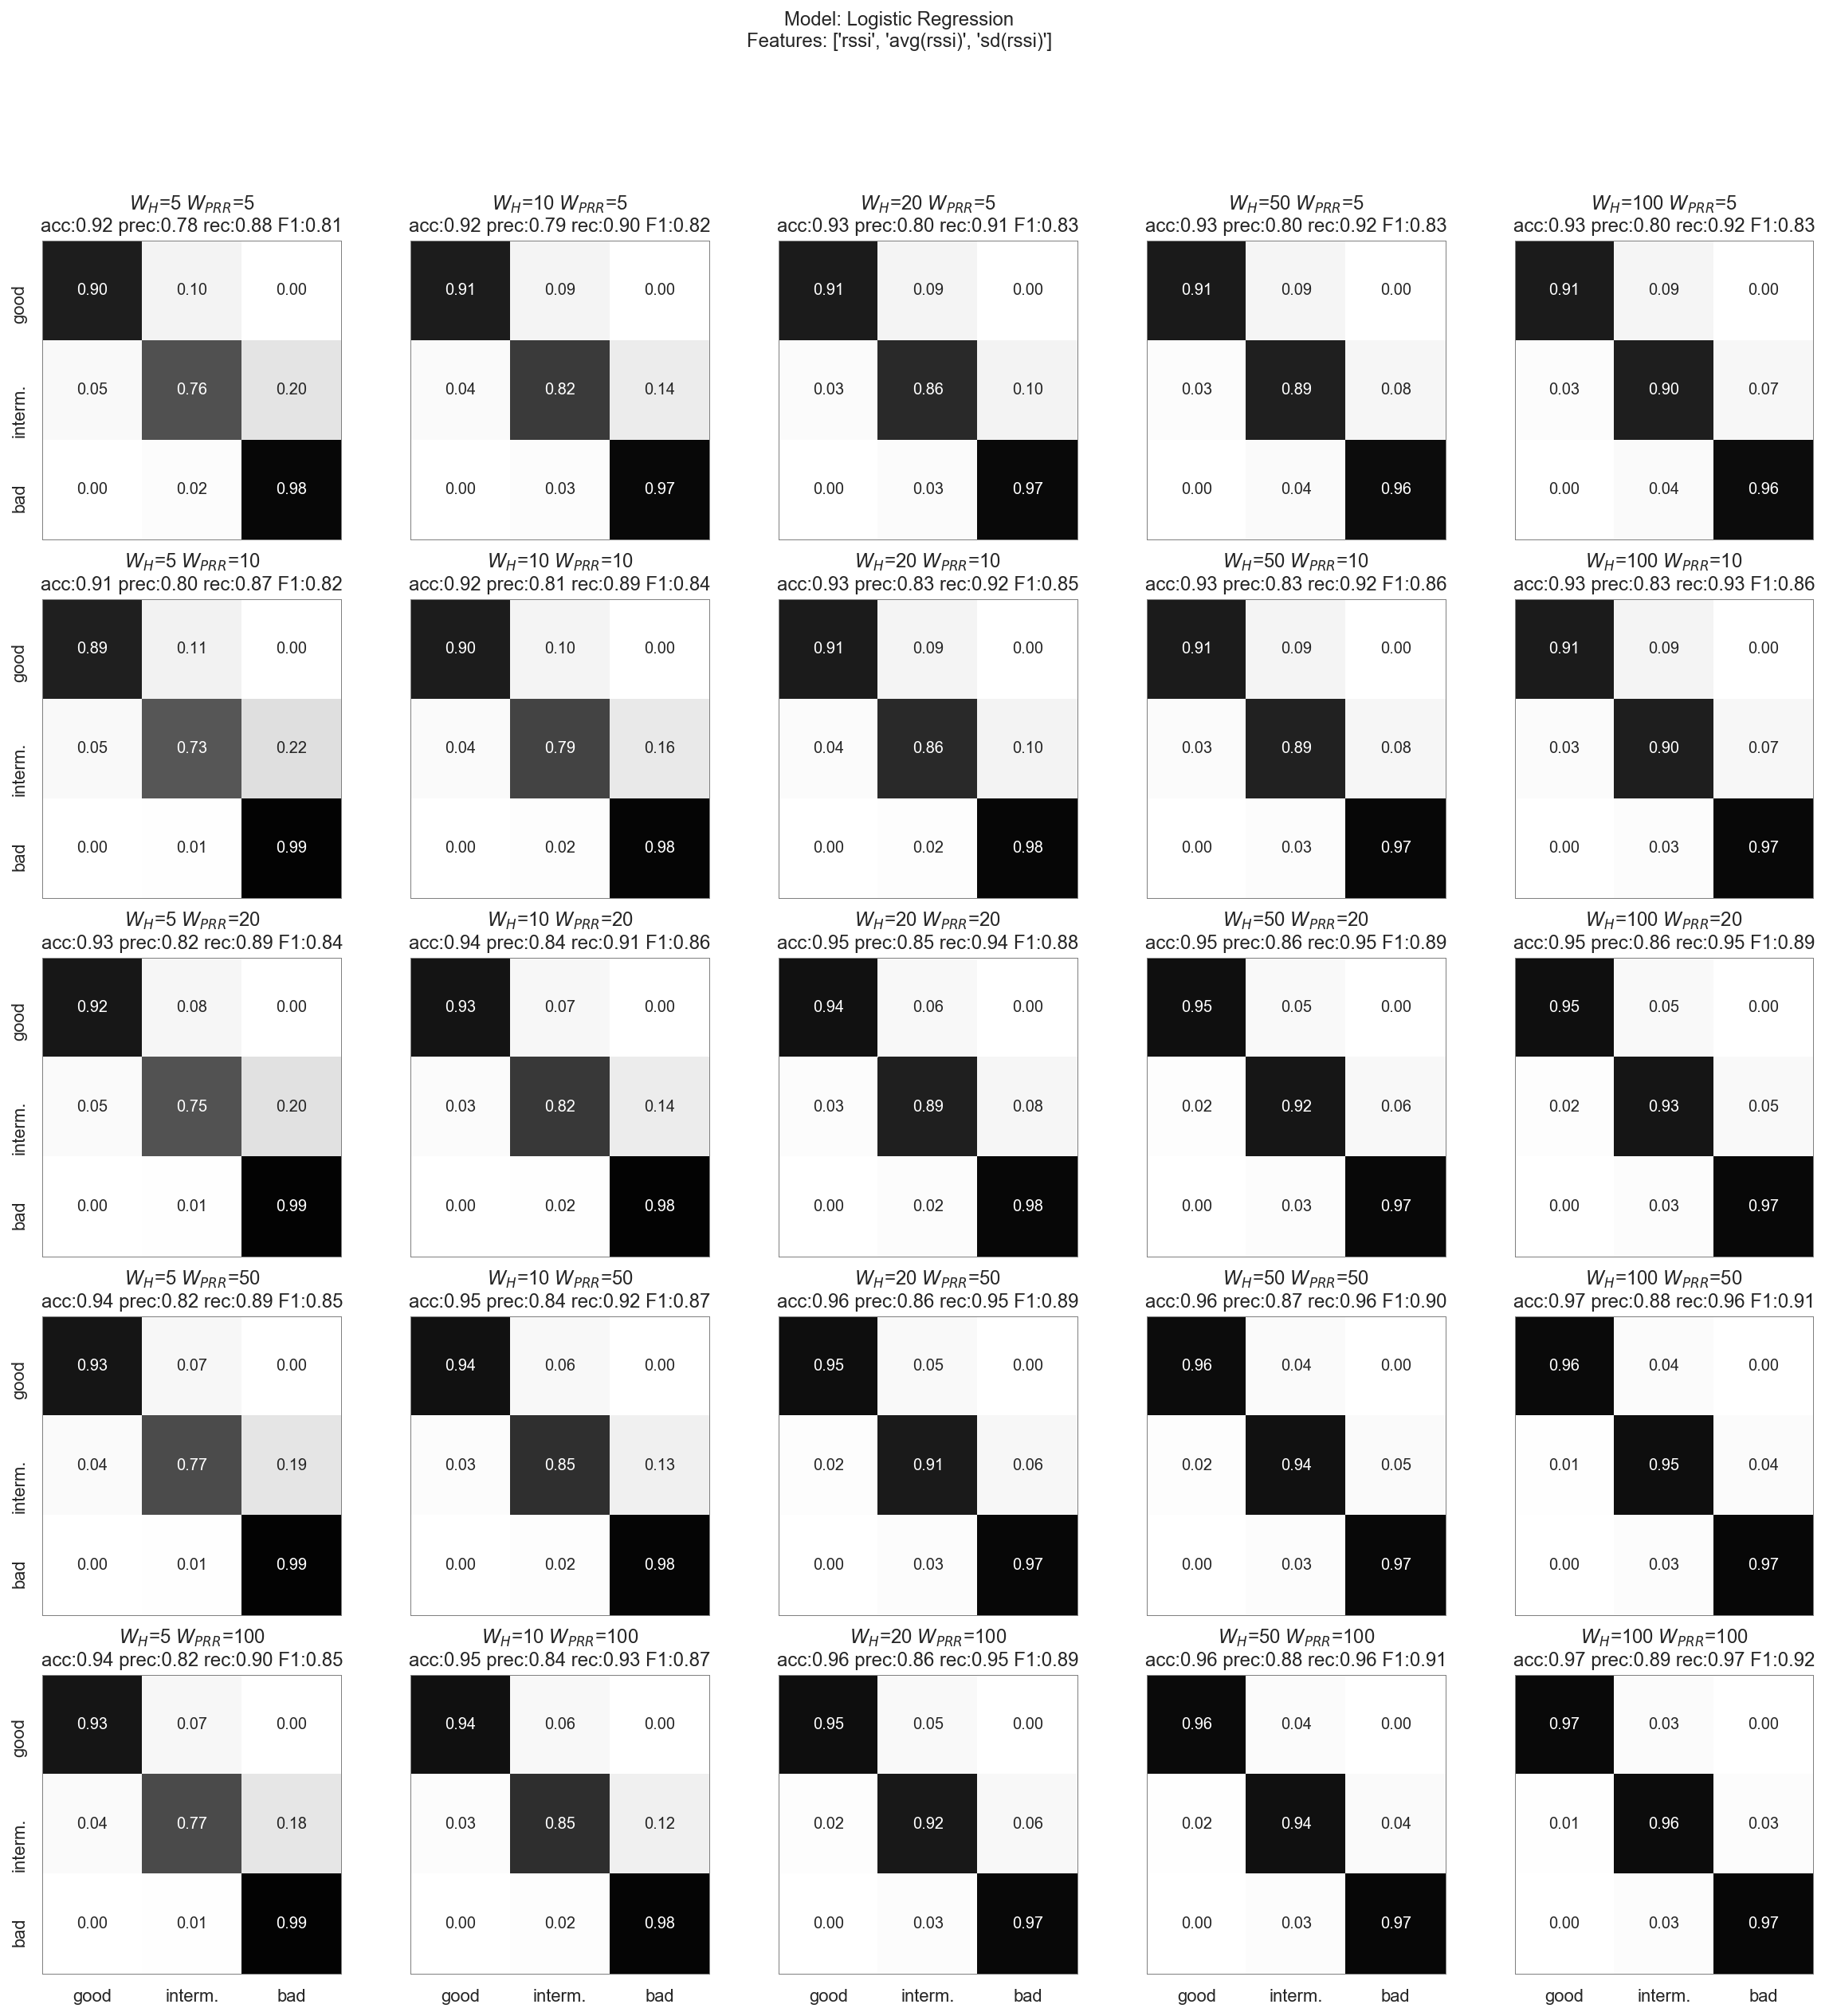

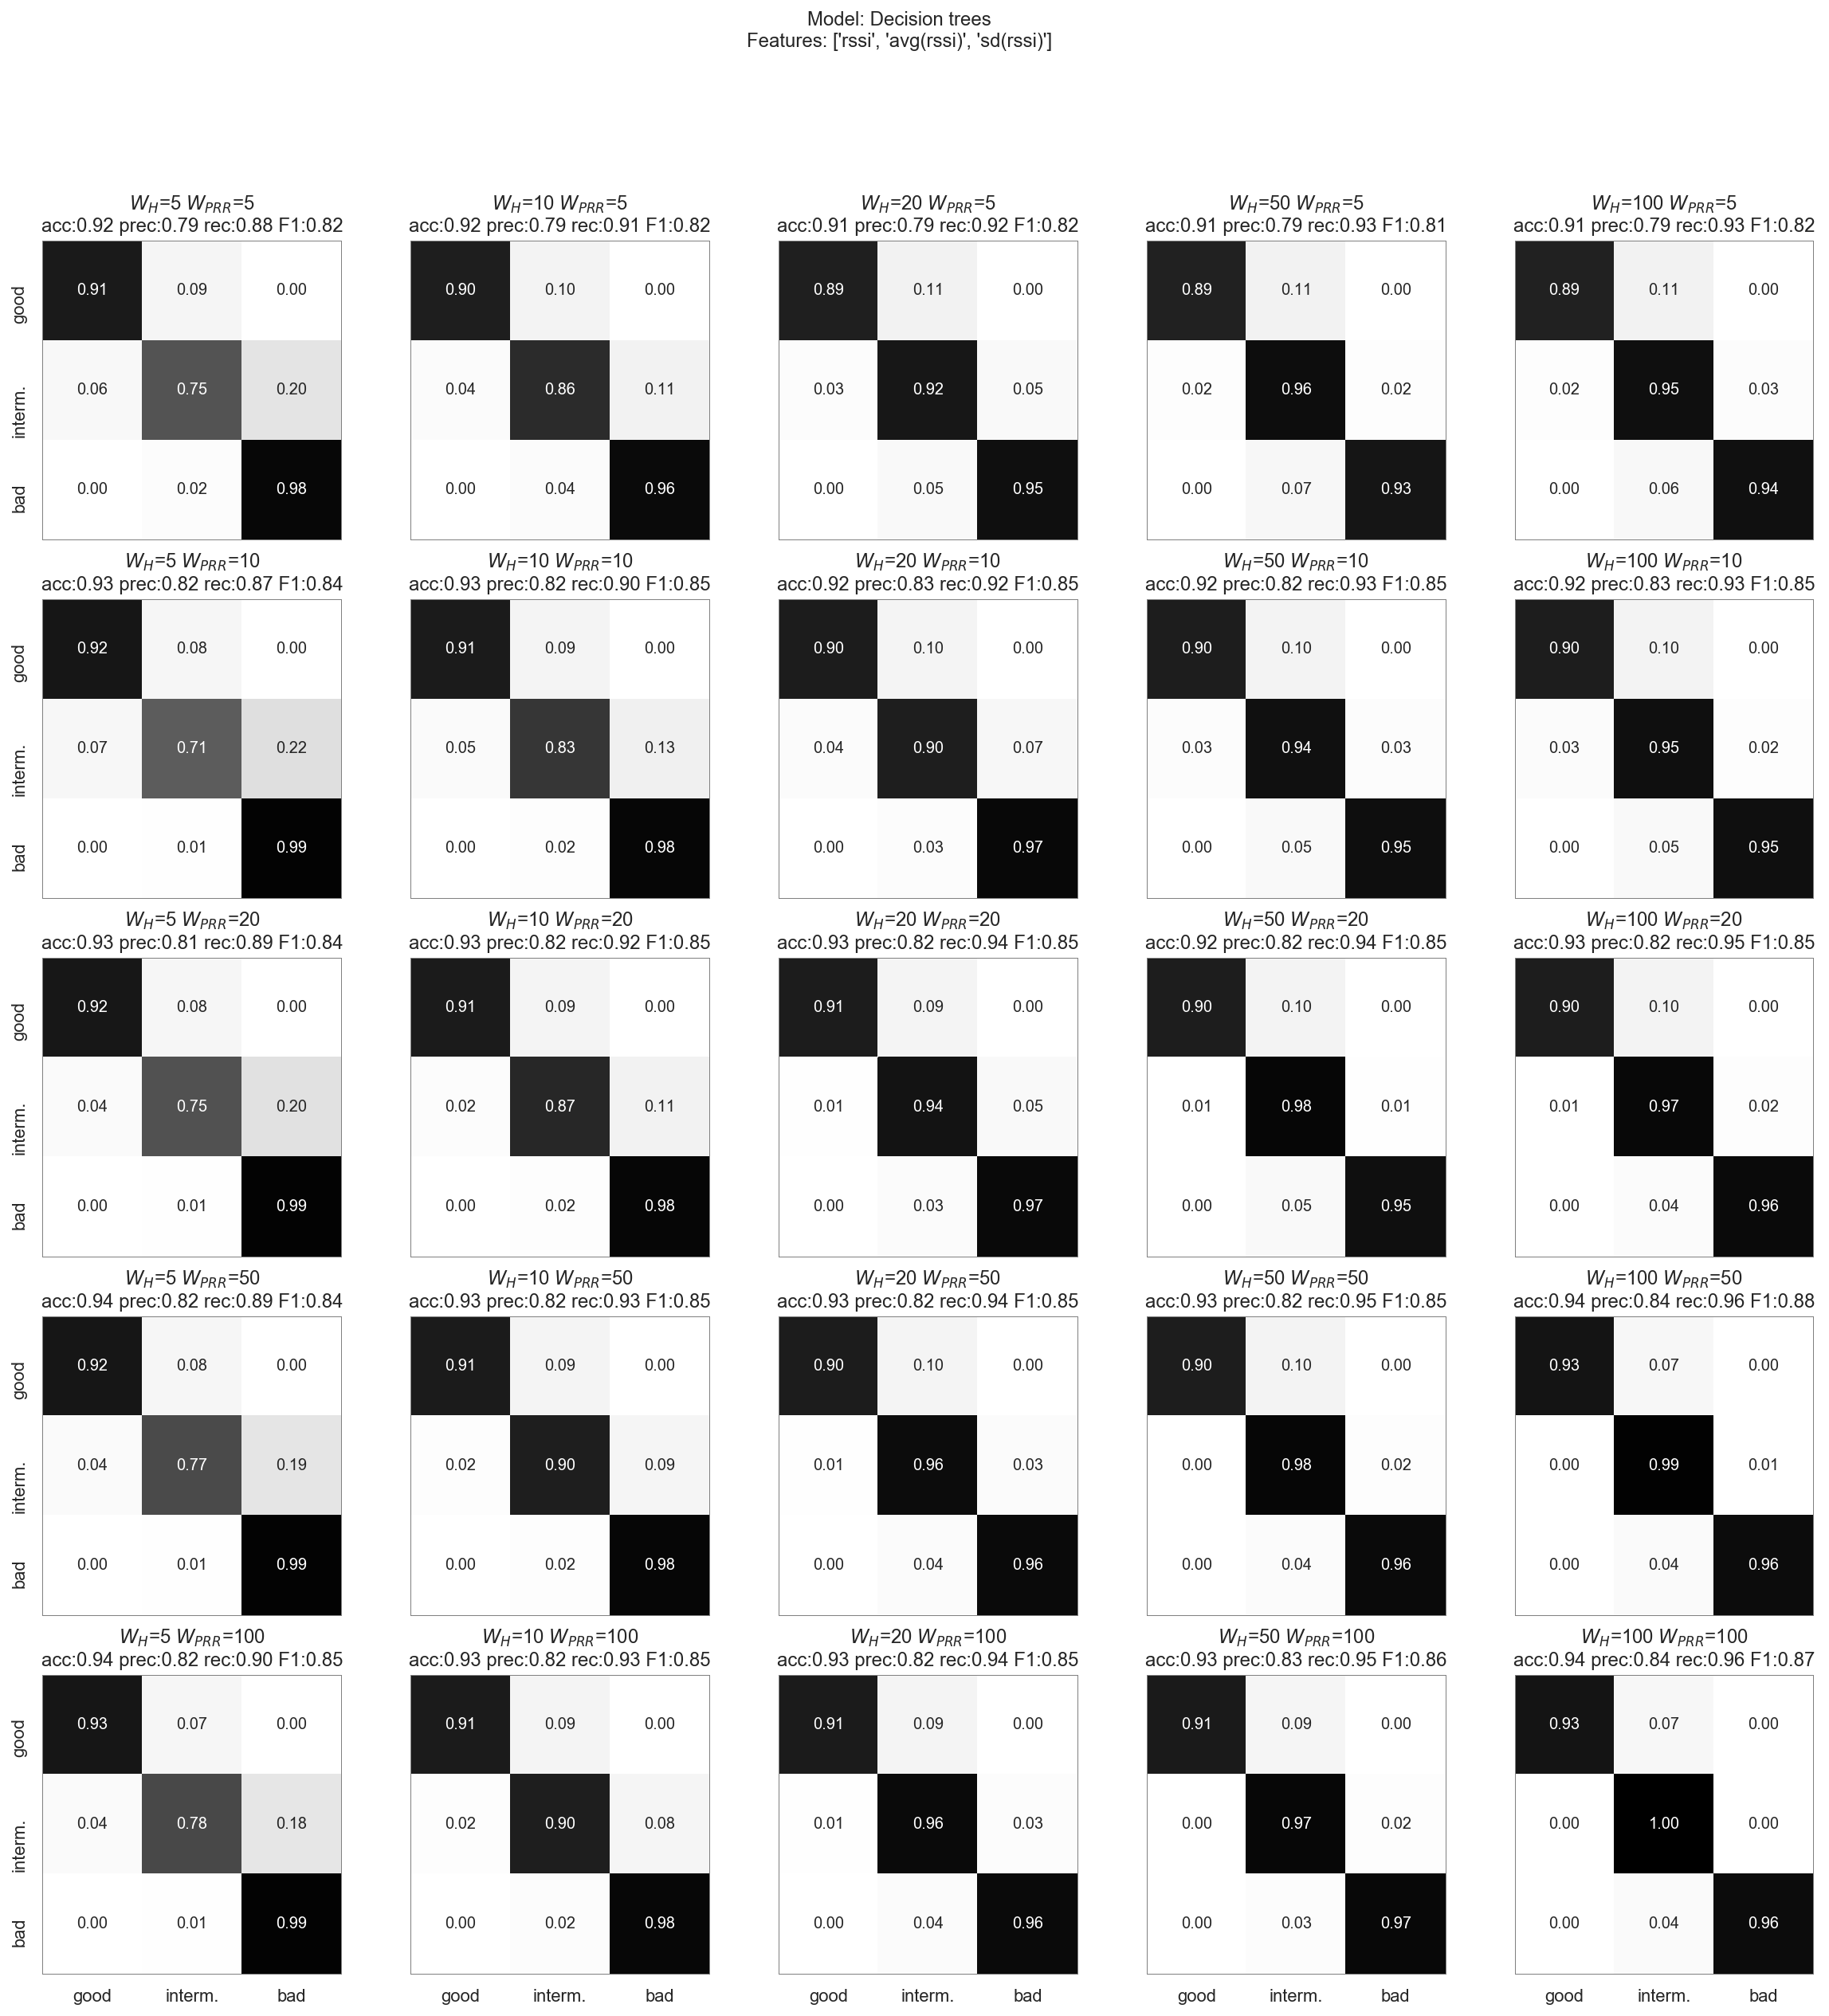

In [20]:
w_sizes = (5, 10, 20, 50, 100)

features = ['rssi', 'avg(rssi)', 'sd(rssi)']

dtree = make_pipeline(
    RandomOverSampler(random_state=SEED),
    StandardScaler(),
    DecisionTreeClassifier(max_depth=3, random_state=SEED)
)

logistic = make_pipeline(
    RandomOverSampler(random_state=SEED),
    StandardScaler(),
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=SEED)
)


f_log, ax_log = plt.subplots(len(w_sizes), len(w_sizes), sharex=True, sharey=True, squeeze=False, figsize=(20,20))
f_log.suptitle(f'Model: Logistic Regression\nFeatures: {features}')

f_dtree, ax_dtree = plt.subplots(len(w_sizes), len(w_sizes), sharex=True, sharey=True, squeeze=False, figsize=(20,20))
f_dtree.suptitle(f'Model: Decision trees\nFeatures: {features}')


results = []

for idx, w_prr in enumerate(w_sizes):
    
    group = df.groupby(['src', 'dst', 'noise'], as_index=False)
    
    df[f'prr'] = group \
        .apply(lambda g: g.sort_values('seq')['received'].rolling(w_prr).sum() / w_prr) \
        .reset_index(level=0)['received'].astype(np.float32)

    df[f'prr+1'] = group \
        .apply(lambda g: (g.sort_values('seq')['received'].rolling(w_prr).sum() / w_prr).shift(-w_prr)) \
        .reset_index(level=0)['received'].astype(np.float32)

    df['label'] = df['prr+1'].apply(set_class)
    
    for idy, w_history in enumerate(w_sizes):
        
        df[f'avg(rssi)'] = group \
            .apply(lambda g: g.sort_values('seq')['rssi'].rolling(w_history).mean()) \
            .reset_index(level=0)['rssi'].astype(np.float32)

        df[f'sd(rssi)'] = group \
            .apply(lambda g: g.sort_values('seq')['rssi'].rolling(w_history).std()) \
            .reset_index(level=0)['rssi'].astype(np.float32)
        
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

        tmp = df[[*features, 'label']].dropna()
        X, y = tmp[features], tmp['label'].ravel()
        
        for model_name, model in [('logistic', logistic), ('dtree', dtree)]:
            y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

            acc = accuracy_score(y, y_pred)
            prec = precision_score(y, y_pred, labels=labels, average='macro')
            rec = recall_score(y, y_pred, labels=labels, average='macro')
            f1 = f1_score(y, y_pred, labels=labels, average='macro')
            cm = confusion_matrix(y, y_pred, labels=labels)

            results.append([model_name, acc, prec, rec, f1])

            title = f'$W_H$={w_history} $W_{{PRR}}$={w_prr}\nacc:{acc:.2f} prec:{prec:.2f} rec:{rec:.2f} F1:{f1:.2f}'
            if model_name == 'dtree':
                plot_cm(cm, labels=labels, ax=ax_dtree[idx, idy], title=title)
            if model_name == 'logistic':
                plot_cm(cm, labels=labels, ax=ax_log[idx, idy], title=title)
        
plt.show(f_log)
plt.show(f_dtree)

plt.close(f_log)
plt.close(f_dtree)